# Test

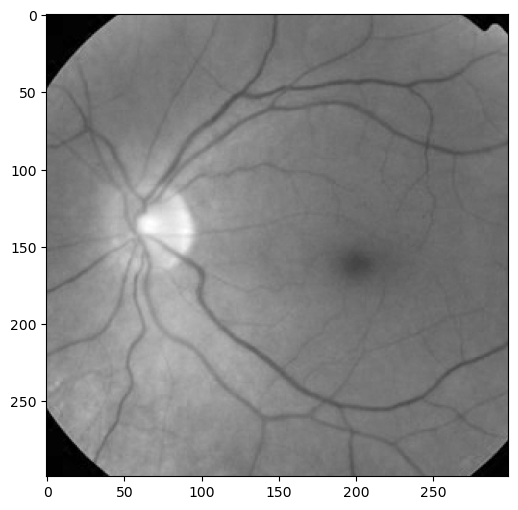

In [8]:
import datasets as d # this is your dataloader module
import torch.utils.data as tData
import matplotlib.pyplot as plt
# Test run with DataLoader wrapper
dataDs = d.MessidorDataset('data/', 'train')
dataLd = tData.DataLoader( dataDs, batch_size=10)
# simulate a single iteration of a for loop
imgBatch,lblBatch = next(iter(dataLd))
# plot
plt.figure("Fundus", (12, 6))
plt.imshow(imgBatch[5, 1, :, :], cmap="gray") # plot the green channel only
plt.show()

# Experiment

In [42]:
#from gpu_configuration import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as skl_mo
import sklearn.metrics as skl_me
import torch
import torch.utils.tensorboard as tb
import torchvision.transforms as transforms
import torch.utils.data as tData
import skimage.io as skiio
import skimage as ski
from tqdm import tqdm
from datetime import datetime
import torchvision.models as tm
import datasets as d # this is your dataloader module
import os

In [55]:
DATA_DIR = 'data/' # location of your data directory
BATCH_SIZE = 32 # your batch size (start small!)
MAX_EPOCHS = 5 # max number of epochs (start small!)
LR = 1e-4 # optimizer learning rate
EXP_ID = "exp-swin-"+str(datetime.now()).replace(" ", "__").replace(":", "-") # name of the experiment
TB_DIR = os.path.join(os.getcwd(),"tb",EXP_ID) # tensorboard directory to view your results ("tb/" will need to be created manually)
WEIGHTS_DIR = 'weights/' # directory to save your weights (create it manually)
image_size = (299,299)
#==
# Select GPU if available or run on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
print(TB_DIR)
if os.path.exists(TB_DIR):
    print(f"The directory '{TB_DIR}' exists.")
else:
    print(f"The directory '{TB_DIR}' does not exist.")
    os.makedirs(TB_DIR, exist_ok=True)

C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab5\tb\exp-swin-2024-11-21__18-12-03.911109
The directory 'C:\Users\gimes\OneDrive\MAIA\3_UdG\classes\MISA\labs\lab5\tb\exp-swin-2024-11-21__18-12-03.911109' exists.


## Transforms

In [25]:
transformAug = transforms.Compose([
    # add your code for additional transform for data augmentation during training
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]) # needed because of tm.Swin_T_Weights.IMAGENET1K_V1
    ])

transformStd = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]) # needed because of tm.Swin_T_Weights.IMAGENET1K_V1
])

## Loaders

In [26]:
# Create data loaders
trainDs = d.MessidorDataset(DATA_DIR, 'train', transformAug)
trainLd = tData.DataLoader( trainDs, batch_size=BATCH_SIZE)
valLd = tData.DataLoader( d.MessidorDataset(DATA_DIR, 'val', transformStd), batch_size=BATCH_SIZE)
testLd = tData.DataLoader( d.MessidorDataset(DATA_DIR, 'test', transformStd), batch_size=BATCH_SIZE)

## Load a pre-built Swin Transformer network with weights learned on image net

Download SWIN weights

In [59]:
# Init Swin Transformer model pretrained on IMAGENET1K_V1
swinWeights = tm.Swin_T_Weights(tm.Swin_T_Weights.IMAGENET1K_V1)

Set weights to the model

In [60]:
model = tm.swin_t(weights=swinWeights)
model = model.to(device)

(optionally) freeze some (or all) network parameters by not allowing the setting requires_grad to False

In [61]:
## Freeze parameters of the first layer
for i, param in enumerate(model.parameters()):
    if i == 0:
        param.requires_grad = False

Swap the classification head with a new torch.nn.Linear for a binary classification problem,as the default one has been pre-trained for a different problem and with 1000 classes. To find out the correct size, try to inspect the model.

In [62]:
print(model.head)

Linear(in_features=768, out_features=1000, bias=True)


In [63]:
model.head = torch.nn.Linear(in_features=768, out_features=2)

Add a weighted cross entropy loss

In [64]:
# loss
cWeight=torch.tensor(trainDs.getClassWeights()).float().to(device) # class weights
loss_function = torch.nn.CrossEntropyLoss(weight=cWeight)

Adam Optimizer

In [65]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), LR)
# instantiate the signoid function
sig = torch.nn.Sigmoid()

## Training & syncronous validation

In [ ]:
import os
from sklearn.metrics import roc_auc_score

# init
print(os.path.exists(TB_DIR))
epoch_loss_values = []
epoch_val_loss_values = []
imgStep = 0
best_val_loss = 1e10
best_val_auc = 0.5
tb_writer = tb.SummaryWriter(log_dir=TB_DIR) # this write the data to Tensorboard.
aucVal = None
# start a tensorboard session to visualize it!
# start training
model = model.to(device)
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{MAX_EPOCHS}")
    epoch_loss, step = 0, 0
    probRetArr = []
    yRetArr = []
    for batchImg, batchLbl in tqdm(trainLd):
        # set model in training mode
        model.train()
        step += 1
        
        # load
        inputs, labels = batchImg.float().to(device), batchLbl.to(device)

        # encode labels into batch x number of classes tensor, i.e. one-hot encoding
        labels = labels.long()
        labelsEnc = torch.nn.functional.one_hot(labels,2).float()
        optimizer.zero_grad()
        
        # Forward pass 
        outputs = model(inputs)
        
        # compute loss
        loss = loss_function(outputs, labelsEnc)
        
        # compute gradients to update the network parameters
        loss.backward()
        # update network parameters
        optimizer.step()
        
        # store current loss
        epoch_loss += loss.item()

        # eval
        with torch.no_grad():
            model.eval()
            # evaluate model again
            outputsEval = model(inputs)
            # Add probabilities and target labels to probRetArr and yRetArr
            probRetArr = np.append(probRetArr, sig(outputsEval[:,1]).cpu().numpy())
            yRetArr= np.append(yRetArr, batchLbl.cpu().numpy())
            
    # Average loss for the epoch
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Compute AUC for training
    aucTrain = roc_auc_score(yRetArr, probRetArr) # Add your code
    
    # Log to TensorBoard
    tb_writer.add_scalar('epoch_train_loss', epoch_loss, epoch)
    tb_writer.add_scalar('epoch_train_auc', aucTrain, epoch)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, auc train {aucTrain:0.3f}")
    
    #==== Validate once per epoch
    epoch_val_loss, step, imgStep = 0, 0, 0
    probRetValArr = []
    yRetArr = []
    model.eval()
    with torch.no_grad():
        for batchImg, batchLbl in tqdm(valLd):
            # add your code for validation
            if aucVal > best_val_auc:
                best_val_auc = aucVal
                torch.save(model.state_dict(), WEIGHTS_DIR+"best_model_weights-"+EXP_ID+".pt")
                print("Saved Best Model!")
    #====    

True
----------
epoch 1/5


 50%|█████     | 8/16 [03:27<03:27, 25.88s/it]

## Testing

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load(WEIGHTS_DIR + "best_model_weights-" + EXP_ID + ".pt"))
model.eval()

# Initialize arrays to store probabilities and true labels
probRetTestArr = []
yRetTestArr = []

# Test loop
with torch.no_grad():
    for batchImg, batchLbl in tqdm(testLd):
        # Move inputs and labels to the correct device
        inputs, labels = batchImg.float().to(device), batchLbl.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store probabilities and true labels
        probRetTestArr = np.append(probRetTestArr, sig(outputs[:, 1]).cpu().numpy())
        yRetTestArr = np.append(yRetTestArr, labels.cpu().numpy())

# Compute AUC for the test set
aucTest = roc_auc_score(yRetTestArr, probRetTestArr)
print(f"Test AUC: {aucTest:.3f}")

# Compute ROC curve
fpr, tpr, thresholds = skl_me.roc_curve(yRetTestArr, probRetTestArr)

# Find the threshold that maximizes sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
sensitivity = tpr[optimal_idx]
specificity = 1 - fpr[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")